# Overview 
- [ ] PDF
- [ ] time series
- [ ] spectra
- [ ] x/y trajectories

In [50]:
import xarray as xr
import pandas as pd
import numpy as np

import os

import hvplot.xarray
import hvplot.pandas

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

import pynsitu as pyn
import lib as lib
from lib import raw_dir, root_dir, images_dir, KEYS, color

import synthetic_traj as st

from synthetic_traj import synthetic_traj, typical_case

In [51]:
## PARAMETERS
t = (50, "1min")
# number of random draws
N = 10

# param_str = f'Period = {t[0]} days, dt = {t[1]}, draws = {N},\n T={typical_case['T']} days, ' +r'$\tau_{\eta}$ =' + str(typical_case['tau_eta']) +' days\n'+ r'$\sigma_{low}$=' + str(typical_case['U_low']) + r'm/s, $\sigma_{ni}$=' + str(typical_case['U_ni'])+ fr'm/s, $\sigma_2$={typical_case['U_2']}m/s, $\sigma_1$={typical_case['U_1']}m/s'

In [53]:
# True value with small dt
ds_true = synthetic_traj(
    t,
    N,
    **typical_case,
    all_comp_pos_acc=True,
)

centred diff
centred diff
105979.84828772297


In [4]:
ds_true

<xarray.Dataset>
Dimensions:    (time: 72001, draw: 10)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 ... 2000-02-20
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
Data variables: (12/48)
    u_low      (time, draw) float64 -0.1805 0.2335 -0.2626 ... 0.3734 -0.1361
    v_low      (time, draw) float64 -0.7333 0.2051 -0.1717 ... 0.7724 0.2124
    u_ni       (time, draw) float64 -0.05126 -0.1318 0.1985 ... 0.02964 -0.1717
    v_ni       (time, draw) float64 0.134 0.05077 -0.1381 ... -0.1127 -0.1215
    u_2        (time, draw) float64 -0.01472 -0.03865 ... 0.01901 -0.02198
    v_2        (time, draw) float64 -0.04383 0.05937 ... 0.01366 0.02425
    ...         ...
    ay_2       (time, draw) float64 1.2e-06 3.696e-06 ... -5.195e-06 2.129e-05
    Axy_2      (time, draw) float64 3.716e-06 4.644e-06 ... 5.283e-06 2.141e-05
    ax_1       (time, draw) float64 -2.769e-06 -1.366e-06 ... 2.175e-07
    ay_1       (time, draw) float64 1.129e-06 -6.973e-08 ... 1.697e-07 2.887e-06
    Axy_1      (time, draw) float64 2.99e-06 1.367e-06 ... 1.695e-06 2.895e-06
    dt         (time, draw) float64 60.0 60.0 60.0 60.0 ... 60.0 60.0 60.0 60.0

In [60]:
nperseg = "20D"
detrend = False

suffix = ["", "_low", "_ni", "_1", "_2"]
Ex_list = []
Eu_list = []
Ea_list = []
for suf in suffix:
    Ex_list.append(
        ds_true.ts.spectrum(
            unit="1D", nperseg=nperseg, complex=("x" + suf, "y" + suf), detrend=detrend
        )
    )
    Eu_list.append(
        ds_true.ts.spectrum(
            unit="1D", nperseg=nperseg, complex=("u" + suf, "v" + suf), detrend=detrend
        )
    )
    Ea_list.append(
        ds_true.ts.spectrum(
            unit="1D",
            nperseg=nperseg,
            complex=("ax" + suf, "ay" + suf),
            detrend=detrend,
        )
    )
Enegpos = xr.merge(Ex_list + Eu_list + Ea_list)


def negpos_spectra(ds, freqkey="frequency"):
    """Return two datasets with cyclonic/anticyclonic spectra"""
    ds_inv = ds.sortby(freqkey, ascending=False)
    dsneg = ds_inv.where(ds_inv[freqkey] <= 0, drop=True)
    dsneg[freqkey] = -dsneg[freqkey]
    dspos = ds.where(ds[freqkey] >= 0, drop=True)
    return dsneg, dspos


Eneg, Epos = negpos_spectra(Enegpos)
Ec = (Eneg + Epos).mean("draw")

______________
# Velocities


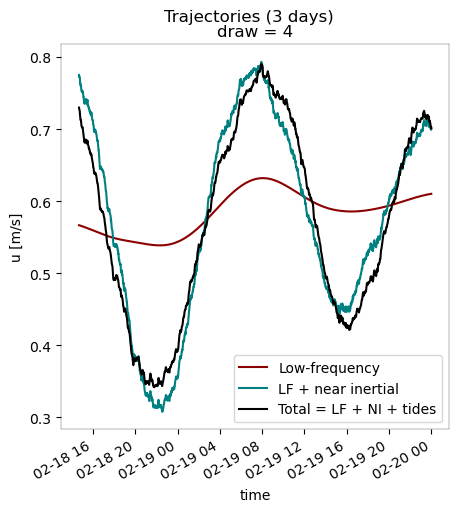

In [61]:
draw = 4
nb_jours = 3
start = 70000
_ds = ds_true.isel(draw=draw).isel(time=slice(start, start + 24 * 60 * nb_jours))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
_ds.u_low.plot(color="darkred", label="Low-frequency")
(_ds.u_ni + _ds.u_low).plot(color="teal", label="LF + near inertial")
_ds.u.plot(color="k", label="Total = LF + NI + tides")
ax.legend()
# ax.set_title(param_str, y=-0.4)
ax.set_ylabel("u [m/s]")
fig.suptitle(f"Trajectories ({nb_jours} days)", y=0.95)
fig.savefig(os.path.join(images_dir, "synth_traj_zoom_traj_comp.png"), dpi=200)

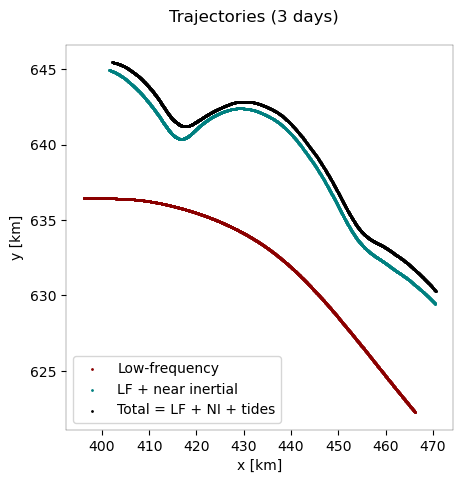

In [62]:
draw = 4
nb_jours = 3
start = 70000
_ds = ds_true.isel(draw=draw).isel(time=slice(start, start + 24 * 60 * nb_jours))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(
    _ds.x_low / 1000, _ds.y_low / 1000, s=1, color="darkred", label="Low-frequency"
)
ax.scatter(
    _ds.x_low / 1000 + _ds.x_ni / 1000,
    _ds.y_low / 1000 + _ds.y_ni / 1000,
    s=1,
    color="teal",
    label="LF + near inertial",
)
ax.scatter(_ds.x / 1000, _ds.y / 1000, s=1, color="k", label="Total = LF + NI + tides")
ax.legend()
# ax.set_title(param_str, y=-0.3)
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
fig.suptitle(f"Trajectories ({nb_jours} days)", y=0.95)
fig.savefig(os.path.join(images_dir, "synth_traj_zoom_traj_comp.png"), dpi=200)

______________
# Correlation

In [9]:
cor_u = sigp.correlate(ds_true.u, ds_true.u).mean("draw")
print(0)
cor_u_low = sigp.correlate(ds_true.u_low, ds_true.u_low).mean("draw")
print(0)
cor_u_ni = sigp.correlate(ds_true.u_ni, ds_true.u_ni).mean("draw")
print(0)
cor_1 = sigp.correlate(ds_true.u_1, ds_true.u_1).mean("draw")
print(0)
cor_2 = sigp.correlate(ds_true.u_2, ds_true.u_2).mean("draw")

0
0
0
0


In [9]:
cor_2["lags"] = cor_2["lags"] / (24 * 3600 * 1e9)


KeyboardInterrupt



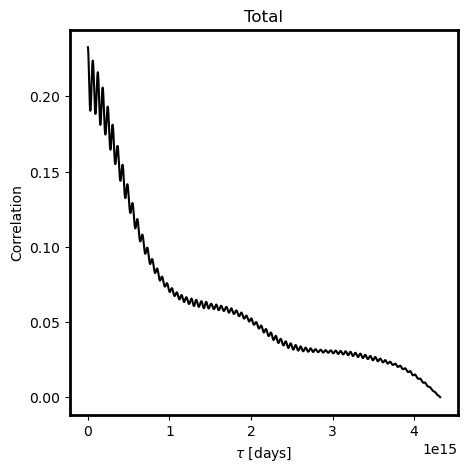

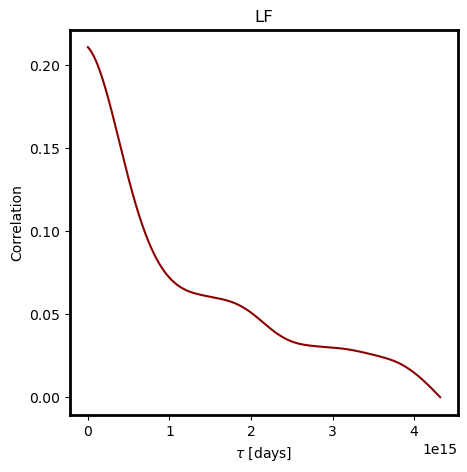

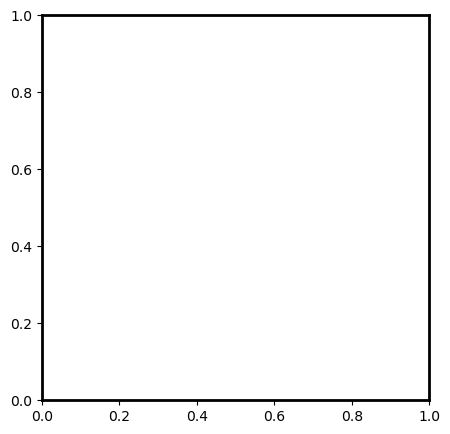

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cor_u.plot(color="k", ax=ax)
ax.set_xlabel(r"$\tau$ [days]")
ax.set_ylabel("Correlation")
ax.set_title("Total")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cor_u_low.plot(color="darkred", ax=ax)
ax.set_xlabel(r"$\tau$ [days]")
ax.set_ylabel("Correlation")
ax.set_title("LF")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cor_u_ni.plot(color="teal", ax=ax)
ax.set_xlabel(r"$\tau$ [days]")
ax.set_ylabel("Correlation")
ax.set_title("NI")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cor_1.plot(color="blue", ax=ax)
ax.set_xlabel(r"$\tau$ [days]")
ax.set_ylabel("Correlation")
ax.set_title("Diurnal tide")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cor_2.plot(color="lightblue", ax=ax)
ax.set_xlabel(r"$\tau$ [days]")
ax.set_ylabel("Correlation")
ax.set_title("Semi-diurnal tide")

______________
# PDF

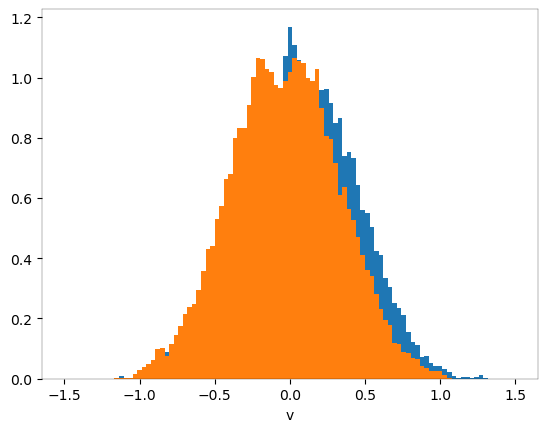

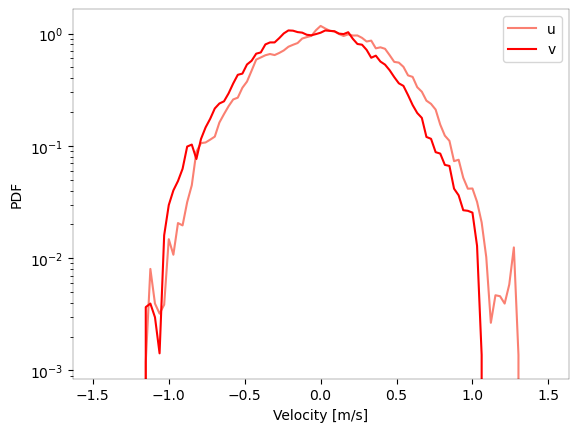

In [63]:
bins = np.linspace(-1.5, 1.5, 100)
histu, b, _ = ds_true.u.plot.hist(bins=bins, density=True)
histv, b, _ = ds_true.v.plot.hist(bins=bins, density=True)
fig, ax = plt.subplots(1, 1)
ax.plot(b[:-1] + np.diff(b) / 2, histu, label="u", color="salmon")
ax.plot(b[:-1] + np.diff(b) / 2, histv, label="v", color="red")
ax.legend()
ax.set_xlabel("Velocity [m/s]")
ax.set_ylabel("PDF")
# ax.set_xscale('log')
ax.set_yscale("log")

______________
# Spectra

In [64]:
def rename_(l):
    s = l.split("_")
    if len(s) == 2:
        a = "E" + l[0]
    elif len(s) == 4:
        a = "E" + "_".join(s[:2])
    else:
        a = l
    if "ax" in a:
        a = a.replace("x", "")
    return a


Ec = Ec.rename({l: rename_(l) for l in Ec.keys()})

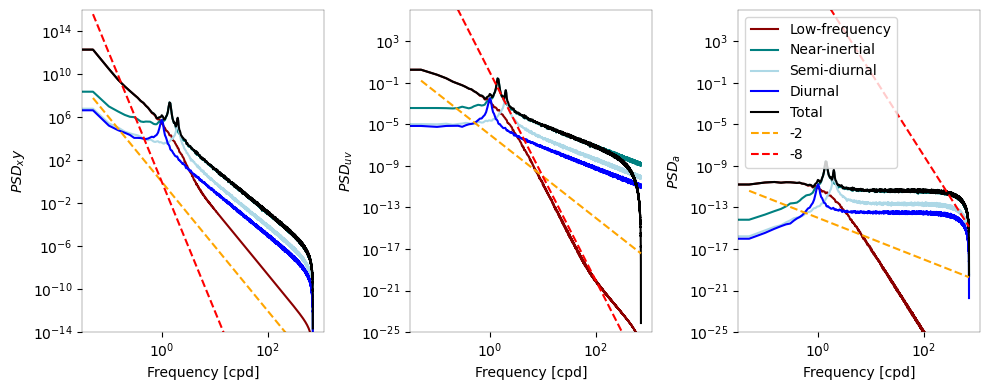

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs = axs.flatten()

ax = axs[0]
Ec.Ex_low.plot(label="Low-frequency", color="darkred", ax=ax)
Ec.Ex_ni.plot(label="Near-inertial", color="teal", ax=ax)
Ec.Ex_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
Ec.Ex_1.plot(label="Diurnal", color="blue", ax=ax)
Ec.Ex.plot(label="Total", color="k", ax=ax)
(Ec.frequency ** (-6)).plot(ax=ax, color="orange", label="-6", ls="--")
(Ec.frequency ** (-12)).plot(ax=ax, color="red", label="-12", ls="--")
ax.set_ylabel(r"$PSD_xy$")
ax.set_xlabel("Frequency [cpd]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-14, 1e16)


ax = axs[1]
Ec.Eu_low.plot(label="Low-frequency", color="darkred", ax=ax)
Ec.Eu_ni.plot(label="Near-inertial", color="teal", ax=ax)
Ec.Eu_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
Ec.Eu_1.plot(label="Diurnal", color="blue", ax=ax)
Ec.Eu.plot(label="Total", color="k", ax=ax)
(Ec.frequency ** (-4) * 1e-6).plot(ax=ax, color="orange", label="-4", ls="--")
(Ec.frequency ** (-10)).plot(ax=ax, color="red", label="-10", ls="--")
ax.set_ylabel(r"$PSD_{uv}$")
ax.set_xlabel("Frequency [cpd]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-25, 1e6)


ax = axs[2]
Ec.Ea_low.plot(label="Low-frequency", color="darkred", ax=ax)
Ec.Ea_ni.plot(label="Near-inertial", color="teal", ax=ax)
Ec.Ea_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
Ec.Ea_1.plot(label="Diurnal", color="blue", ax=ax)
Ec.Ea.plot(label="Total", color="k", ax=ax)
(Ec.frequency ** (-2) * 1e-14).plot(ax=ax, color="orange", label="-2", ls="--")
(Ec.frequency ** (-8) * 1e8).plot(ax=ax, color="red", label="-8", ls="--")
ax.set_ylabel(r"$PSD_a$")
ax.set_xlabel("Frequency [cpd]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(1e-25, 1e6)
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(images_dir, "synth_traj_vel_spectra.png"))

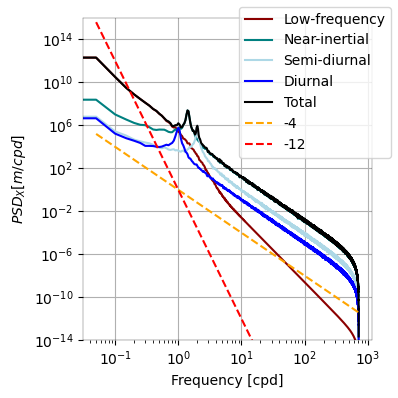

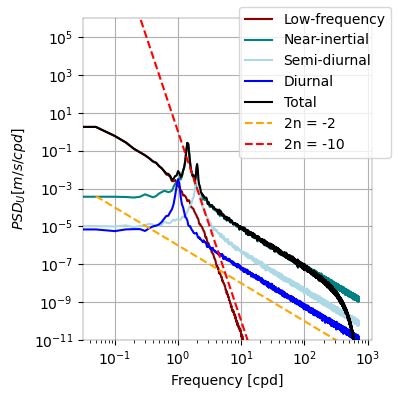

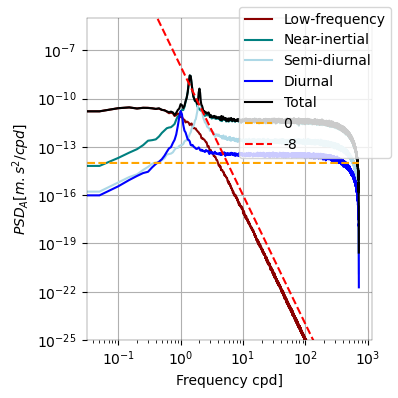

In [66]:
fig0, ax = plt.subplots(1, 1, figsize=(4, 4))

Ec.Ex_low.plot(label="Low-frequency", color="darkred", ax=ax)
Ec.Ex_ni.plot(label="Near-inertial", color="teal", ax=ax)
Ec.Ex_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
Ec.Ex_1.plot(label="Diurnal", color="blue", ax=ax)
Ec.Ex.plot(label="Total", color="k", ax=ax)
(Ec.frequency ** (-4)).plot(ax=ax, color="orange", label="-4", ls="--")
(Ec.frequency ** (-12)).plot(ax=ax, color="red", label="-12", ls="--")
ax.set_ylabel(r"$PSD_{X} [m/cpd]$")
ax.set_xlabel("Frequency [cpd]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.set_ylim(1e-14, 1e16)
fig0.legend()
fig0.tight_layout()
# ax.set_title(param_str, y=-0.4)
fig0.savefig(os.path.join(images_dir, "synth_traj_xy_spectra.png"), dpi=200)

fig1, ax = plt.subplots(1, 1, figsize=(4, 4))
Ec.Eu_low.plot(label="Low-frequency", color="darkred", ax=ax)
Ec.Eu_ni.plot(label="Near-inertial", color="teal", ax=ax)
Ec.Eu_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
Ec.Eu_1.plot(label="Diurnal", color="blue", ax=ax)
Ec.Eu.plot(label="Total", color="k", ax=ax)
(Ec.frequency ** (-2) * 1e-6).plot(ax=ax, color="orange", label="2n = -2", ls="--")
(Ec.frequency ** (-10)).plot(ax=ax, color="red", label="2n = -10", ls="--")
ax.set_ylabel(r"$PSD_{U} [m/s/cpd]$")
ax.set_xlabel("Frequency [cpd]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.set_ylim(1e-11, 1e6)
fig1.legend()
# fig1.suptitle(param_str)
fig1.tight_layout()
fig1.savefig(os.path.join(images_dir, "synth_traj_vel_spectra.png"), dpi=200)

fig2, ax = plt.subplots(1, 1, figsize=(4, 4))
Ec.Ea_low.plot(label="Low-frequency", color="darkred", ax=ax)
Ec.Ea_ni.plot(label="Near-inertial", color="teal", ax=ax)
Ec.Ea_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
Ec.Ea_1.plot(label="Diurnal", color="blue", ax=ax)
Ec.Ea.plot(label="Total", color="k", ax=ax)
(Ec.frequency ** (0) * 1e-14).plot(ax=ax, color="orange", label="0", ls="--")
(Ec.frequency ** (-8) * 1e-8).plot(ax=ax, color="red", label="-8", ls="--")
ax.set_ylabel(r"$PSD_A [m.s^2/cpd]$")
ax.set_xlabel("Frequency cpd]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.set_ylim(1e-25, 1e-5)
fig2.legend()
# ax.set_title(param_str, y=-0.4)
fig2.tight_layout()
fig2.savefig(os.path.join(images_dir, "synth_traj_acc_spectra.png"), dpi=200)

In [67]:
Enegpos

<xarray.Dataset>
Dimensions:        (draw: 10, frequency: 28800)
Coordinates:
  * draw           (draw) int64 0 1 2 3 4 5 6 7 8 9
  * frequency      (frequency) float64 -720.0 -720.0 -719.9 ... 719.9 720.0
Data variables: (12/15)
    x_y            (draw, frequency) float64 2.722e-15 1.44e-14 ... 1.441e-14
    x_low_y_low    (draw, frequency) float64 6.212e-22 2.68e-21 ... 2.103e-21
    x_ni_y_ni      (draw, frequency) float64 2.341e-15 1.213e-14 ... 1.32e-14
    x_1_y_1        (draw, frequency) float64 3.585e-17 4.222e-17 ... 1.199e-16
    x_2_y_2        (draw, frequency) float64 9.448e-17 6.963e-16 ... 4.61e-16
    u_v            (draw, frequency) float64 1.226e-26 5.046e-25 ... 4.644e-25
    ...             ...
    u_2_v_2        (draw, frequency) float64 1.581e-11 2.736e-11 ... 3.002e-11
    ax_ay          (draw, frequency) float64 3.362e-21 1.776e-20 ... 1.779e-20
    ax_low_ay_low  (draw, frequency) float64 1.507e-31 1.983e-31 ... 4.015e-32
    ax_ni_ay_ni    (draw, frequency) float64 2.89e-21 1.498e-20 ... 1.63e-20
    ax_1_ay_1      (draw, frequency) float64 4.425e-23 5.212e-23 ... 1.48e-22
    ax_2_ay_2      (draw, frequency) float64 1.166e-22 8.596e-22 ... 5.691e-22

In [68]:
E = Enegpos.mean("draw").rename({l: rename_(l) for l in Enegpos.keys()})

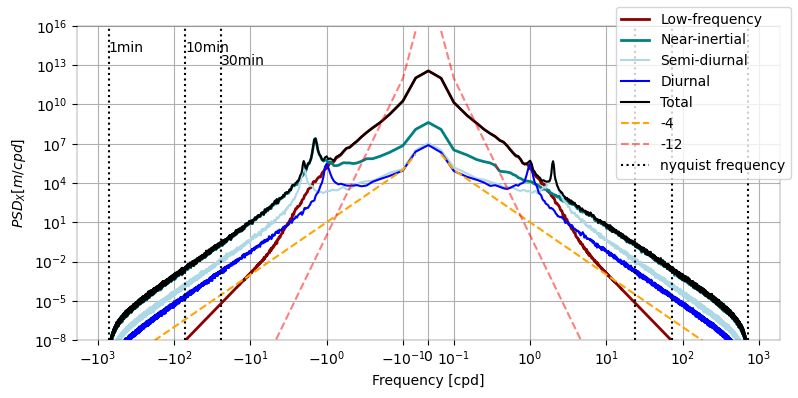

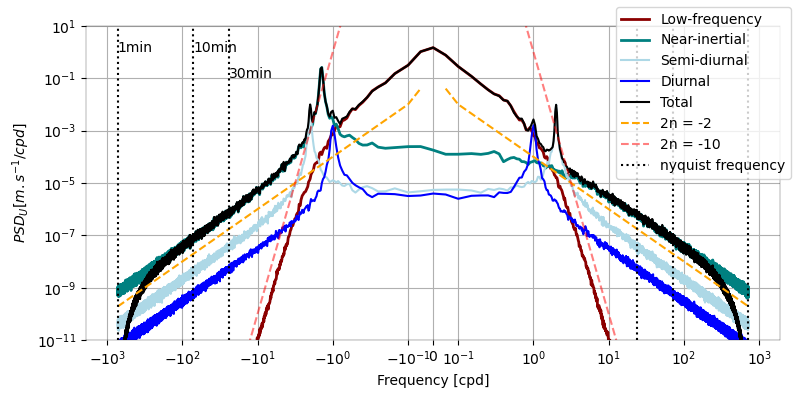

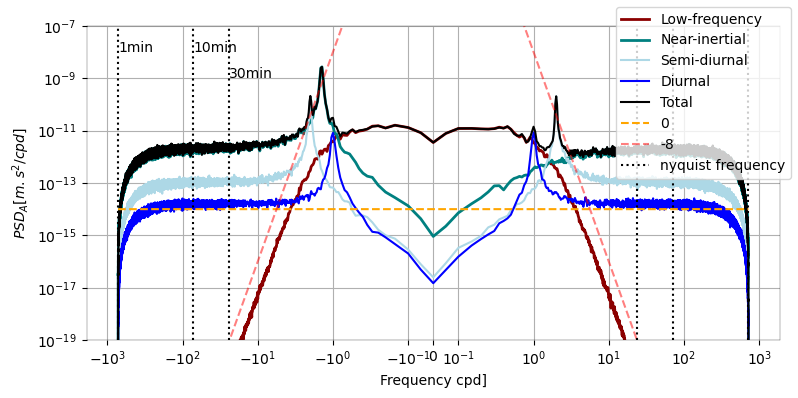

In [74]:
linthresh = 1e-1
linscale = 0.3
fig0, ax = plt.subplots(1, 1, figsize=(8, 4))

E.Ex_low.plot(label="Low-frequency", color="darkred", ax=ax, lw=2)
E.Ex_ni.plot(label="Near-inertial", color="teal", ax=ax, lw=2)
E.Ex_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
E.Ex_1.plot(label="Diurnal", color="blue", ax=ax)
E.Ex.plot(label="Total", color="k", ax=ax)
(E.frequency ** (-4) * 1e1).plot(ax=ax, color="orange", label="-4", ls="--")
(E.frequency ** (-12)).plot(ax=ax, color="red", label="-12", ls="--", alpha=0.5)
ax.set_ylabel(r"$PSD_{X} [m/cpd]$")
ax.set_xlabel("Frequency [cpd]")
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.grid()
ax.axvline(-24 * 60 / 10 / 2, color="k", ls=":", label="nyquist frequency")
ax.axvline(-24 * 60 / 30 / 2, color="k", ls=":")
ax.axvline(-24 * 60 / 2, color="k", ls=":")
ax.annotate("10min", (-24 * 60 / 10 / 2, 1e14))
ax.annotate("30min", (-24 * 60 / 30 / 2, 1e13))
ax.annotate("1min", (-24 * 60 / 2, 1e14))
ax.axvline(24 * 60 / 10 / 2, color="k", ls=":")
ax.axvline(24 * 60 / 30 / 2, color="k", ls=":")
ax.axvline(24 * 60 / 2, color="k", ls=":")
ax.set_ylim(1e-8, 1e16)
fig0.legend()
fig0.tight_layout()
# ax.set_title(param_str, y=-0.4)
fig0.savefig(os.path.join(images_dir, "synth_traj_xy_spectra_typ.png"), dpi=200)

fig1, ax = plt.subplots(1, 1, figsize=(8, 4))
E.Eu_low.plot(label="Low-frequency", color="darkred", ax=ax, lw=2)
E.Eu_ni.plot(label="Near-inertial", color="teal", ax=ax, lw=2)
E.Eu_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
E.Eu_1.plot(label="Diurnal", color="blue", ax=ax)
E.Eu.plot(label="Total", color="k", ax=ax)
(E.frequency ** (-2) * 1e-4).plot(ax=ax, color="orange", label="2n = -2", ls="--")
(E.frequency ** (-10)).plot(ax=ax, color="red", label="2n = -10", ls="--", alpha=0.5)
ax.set_ylabel(r"$PSD_{U} [m.s^{-1}/cpd]$")
ax.set_xlabel("Frequency [cpd]")
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.grid()
ax.axvline(-24 * 60 / 10 / 2, color="k", ls=":", label="nyquist frequency")
ax.axvline(-24 * 60 / 30 / 2, color="k", ls=":")
ax.axvline(-24 * 60 / 2, color="k", ls=":")
ax.annotate("10min", (-24 * 60 / 10 / 2, 1e0))
ax.annotate("30min", (-24 * 60 / 30 / 2, 1e-1))
ax.annotate("1min", (-24 * 60 / 2, 1e0))
ax.axvline(24 * 60 / 10 / 2, color="k", ls=":")
ax.axvline(24 * 60 / 30 / 2, color="k", ls=":")
ax.axvline(24 * 60 / 2, color="k", ls=":")
ax.set_ylim(1e-11, 1e1)
fig1.legend()
# fig1.suptitle(param_str)
fig1.tight_layout()
fig1.savefig(os.path.join(images_dir, "synth_traj_vel_spectra_typ.png"), dpi=200)

fig2, ax = plt.subplots(1, 1, figsize=(8, 4))
E.Ea_low.plot(label="Low-frequency", color="darkred", ax=ax, lw=2)
E.Ea_ni.plot(label="Near-inertial", color="teal", ax=ax, lw=2)
E.Ea_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
E.Ea_1.plot(label="Diurnal", color="blue", ax=ax)
E.Ea.plot(label="Total", color="k", ax=ax)
(E.frequency ** (0) * 1e-14).plot(ax=ax, color="orange", label="0", ls="--")
(E.frequency ** (-8) * 1e-8).plot(ax=ax, color="red", label="-8", ls="--", alpha=0.5)
ax.set_ylabel(r"$PSD_A [m.s^2/cpd]$")
ax.set_xlabel("Frequency cpd]")
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.grid()
ax.axvline(-24 * 60 / 10 / 2, color="k", ls=":", label="nyquist frequency")
ax.axvline(-24 * 60 / 30 / 2, color="k", ls=":")
ax.axvline(-24 * 60 / 2, color="k", ls=":")
ax.annotate("10min", (-24 * 60 / 10 / 2, 1e-8))
ax.annotate("30min", (-24 * 60 / 30 / 2, 1e-9))
ax.annotate("1min", (-24 * 60 / 2, 1e-8))
ax.axvline(24 * 60 / 10 / 2, color="k", ls=":")
ax.axvline(24 * 60 / 30 / 2, color="k", ls=":")
ax.axvline(24 * 60 / 2, color="k", ls=":")
ax.set_ylim(1e-19, 1e-7)
fig2.legend()
# ax.set_title(param_str, y=-0.4)
fig2.tight_layout()
fig2.savefig(os.path.join(images_dir, "synth_traj_acc_spectra_typ.png"), dpi=200)

______________
# Time series

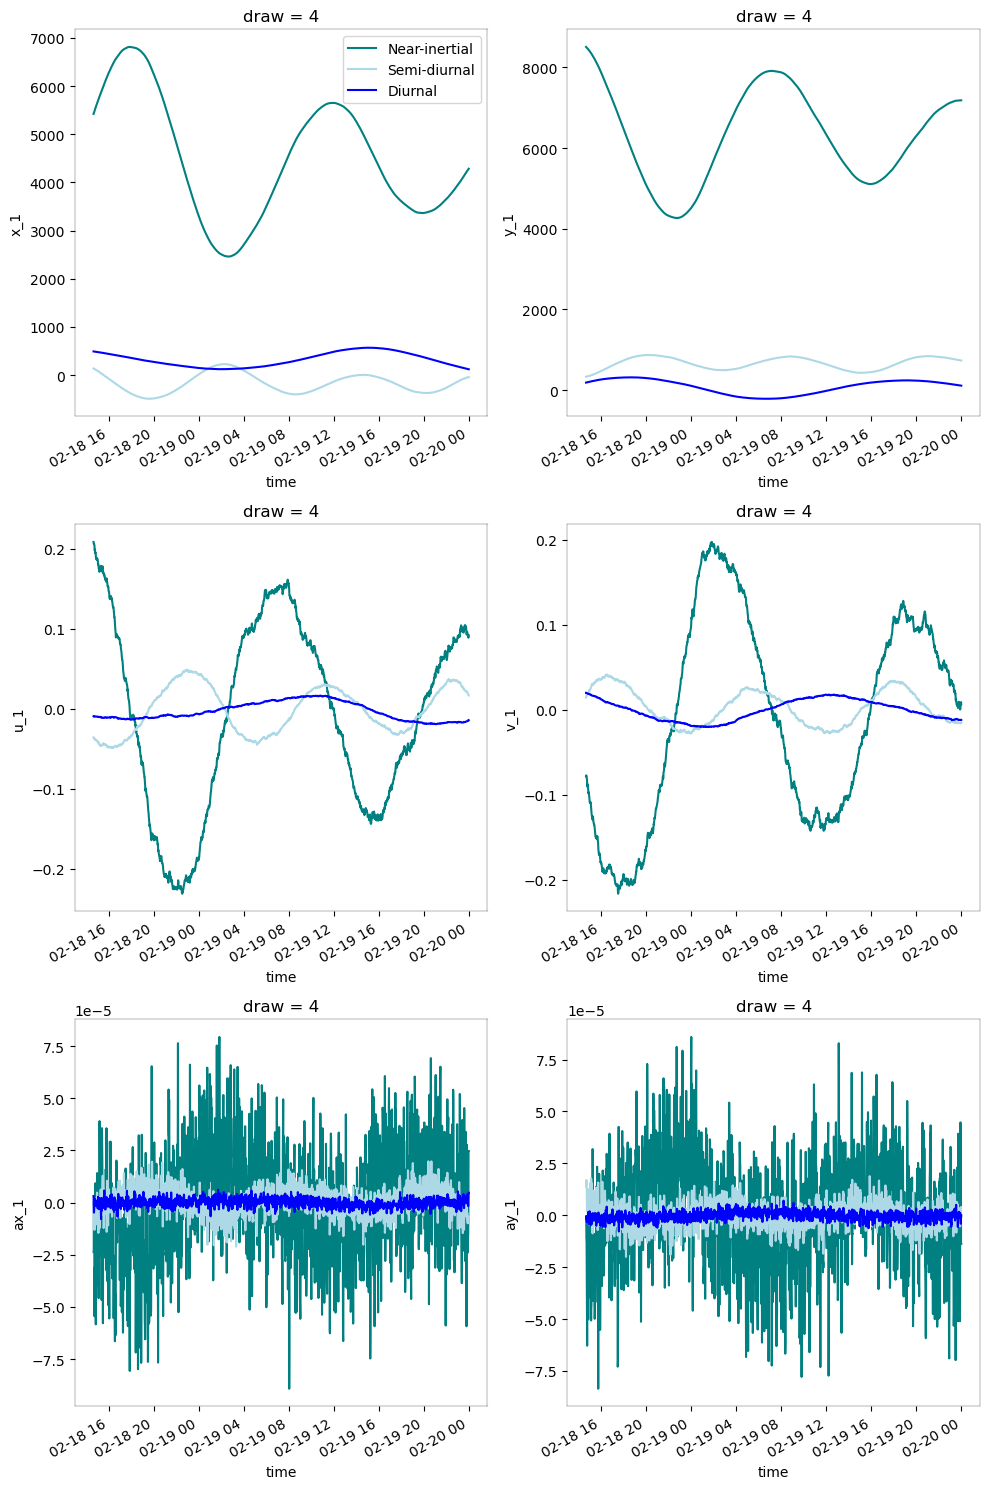

In [42]:
draw = 4
nb_jours = 3
start = 70000
ds_ = ds_true.isel(draw=draw).isel(time=slice(start, start + 24 * 60 * nb_jours))

fig, axs = plt.subplots(3, 2, figsize=(10, 15))
axs = axs.flatten()

ax = axs[0]
# ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.x_ni.plot(label="Near-inertial", color="teal", ax=ax)
ds_.x_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
ds_.x_1.plot(label="Diurnal", color="blue", ax=ax)
ax.legend()

ax = axs[1]
# ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.y_ni.plot(label="Near-inertial", color="teal", ax=ax)
ds_.y_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
ds_.y_1.plot(label="Diurnal", color="blue", ax=ax)

ax = axs[2]
# ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.u_ni.plot(label="Near-inertial", color="teal", ax=ax)
ds_.u_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
ds_.u_1.plot(label="Diurnal", color="blue", ax=ax)

ax = axs[3]
# ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.v_ni.plot(label="Near-inertial", color="teal", ax=ax)
ds_.v_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
ds_.v_1.plot(label="Diurnal", color="blue", ax=ax)

ax = axs[4]
# ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.ax_ni.plot(label="Near-inertial", color="teal", ax=ax)
ds_.ax_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
ds_.ax_1.plot(label="Diurnal", color="blue", ax=ax)

ax = axs[5]
# ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.ay_ni.plot(label="Near-inertial", color="teal", ax=ax)
ds_.ay_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
ds_.ay_1.plot(label="Diurnal", color="blue", ax=ax)

fig.tight_layout()

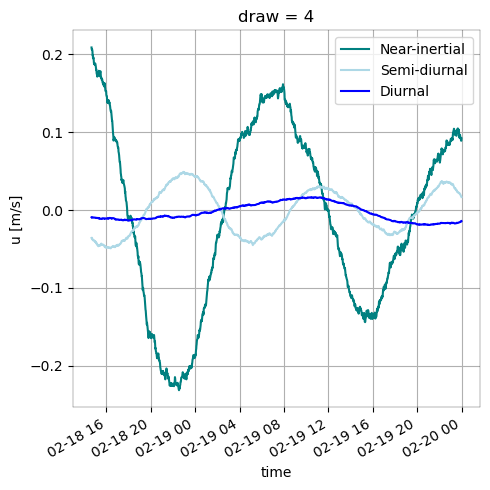

In [46]:
draw = 4
nb_jours = 3
start = 70000
ds_ = ds_true.isel(draw=draw).isel(time=slice(start, start + 24 * 60 * nb_jours))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# ds_.x_low.plot(label = 'Low-frequency', color = 'darkred', ax=ax)
ds_.u_ni.plot(label="Near-inertial", color="teal", ax=ax)
ds_.u_2.plot(label="Semi-diurnal", color="lightblue", ax=ax)
ds_.u_1.plot(label="Diurnal", color="blue", ax=ax)
ax.set_ylabel("u [m/s]")
ax.grid()
ax.legend()
# ax.set_title(param_str, y=-0.5)
fig.tight_layout()

______________
# X/Y plot

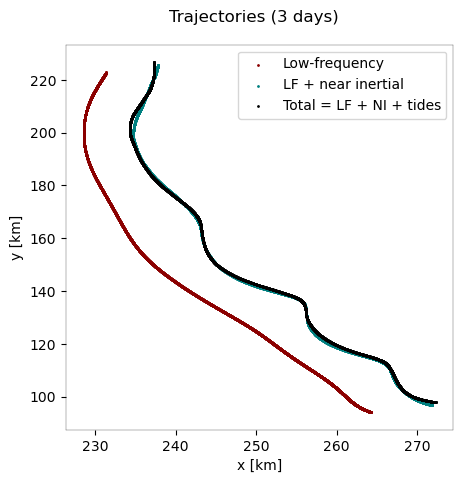

In [50]:
draw = 4
nb_jours = 3
start = 50000
_ds = ds_true.isel(draw=draw).isel(time=slice(start, start + 24 * 60 * nb_jours))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(
    _ds.x_low / 1000, _ds.y_low / 1000, s=1, color="darkred", label="Low-frequency"
)
ax.scatter(
    _ds.x_low / 1000 + _ds.x_ni / 1000,
    _ds.y_low / 1000 + _ds.y_ni / 1000,
    s=1,
    color="teal",
    label="LF + near inertial",
)
ax.scatter(_ds.x / 1000, _ds.y / 1000, s=1, color="k", label="Total = LF + NI + tides")
ax.legend()
# ax.set_title(param_str, y=-0.3)
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
fig.suptitle(f"Trajectories ({nb_jours} days)", y=0.95)
fig.savefig(os.path.join(images_dir, "synth_traj_zoom_traj_comp.png"), dpi=200)

In [52]:
ds_true

<xarray.Dataset>
Dimensions:    (time: 72001, draw: 10)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 ... 2000-02-20
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
Data variables: (12/48)
    u_low      (time, draw) float64 -0.1805 0.2335 -0.2626 ... 0.3734 -0.1361
    v_low      (time, draw) float64 -0.7333 0.2051 -0.1717 ... 0.7724 0.2124
    u_ni       (time, draw) float64 -0.05126 -0.1318 0.1985 ... 0.02964 -0.1717
    v_ni       (time, draw) float64 0.134 0.05077 -0.1381 ... -0.1127 -0.1215
    u_2        (time, draw) float64 -0.01472 -0.03865 ... 0.01901 -0.02198
    v_2        (time, draw) float64 -0.04383 0.05937 ... 0.01366 0.02425
    ...         ...
    ay_2       (time, draw) float64 1.2e-06 3.696e-06 ... -5.195e-06 2.129e-05
    Axy_2      (time, draw) float64 3.716e-06 4.644e-06 ... 5.283e-06 2.141e-05
    ax_1       (time, draw) float64 -2.769e-06 -1.366e-06 ... 2.175e-07
    ay_1       (time, draw) float64 1.129e-06 -6.973e-08 ... 1.697e-07 2.887e-06
    Axy_1      (time, draw) float64 2.99e-06 1.367e-06 ... 1.695e-06 2.895e-06
    dt         (time, draw) float64 60.0 60.0 60.0 60.0 ... 60.0 60.0 60.0 60.0

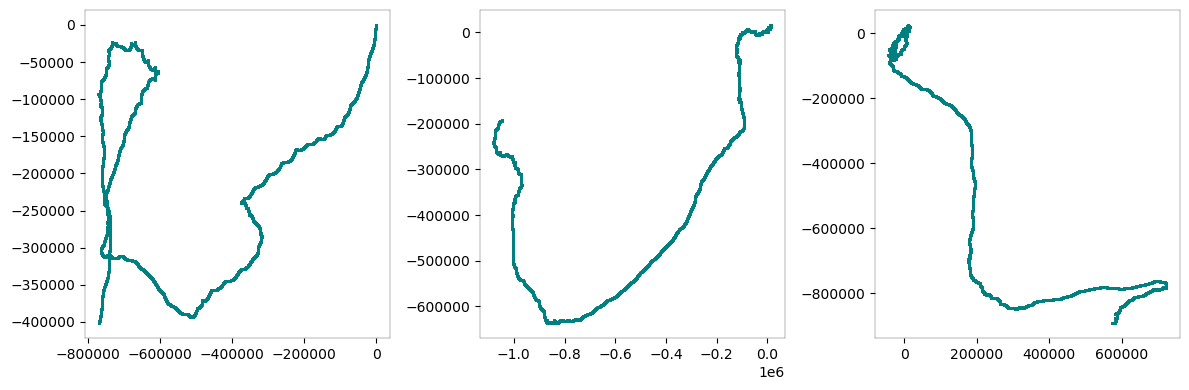

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.flatten()
for i in range(len(axs)):
    ax = axs[i]
    _ds = ds_true.isel(draw=i)
    ax.scatter(_ds.x, _ds.y, s=1, color="teal")
fig.tight_layout()

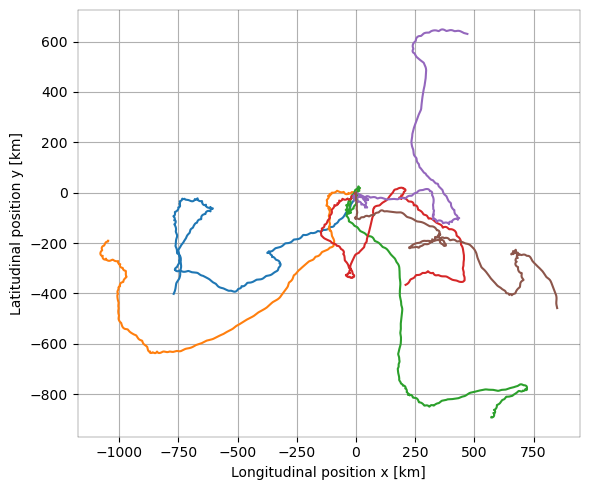

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# axs = axs.flatten()
for i in range(6):
    _ds = xr.DataArray(
        data=ds_true.y.isel(draw=i) / 1000,
        coords={"x": ds_true.x.isel(draw=i).values / 1000},
        dims="x",
    )
    _ds.plot(ax=ax)
ax.grid()
ax.set_xlabel("Longitudinal position x [km]")
ax.set_ylabel("Latitudinal position y [km]")
fig.tight_layout()
fig.savefig(os.path.join(images_dir, "synth_traj_5traj.png"), dpi=200)